# European Union Curve Flattening and Adjusted Recovered Rate
> This dashboard visualizes the flattening of the curve in total for all 27 countries of the European Union as well as an adjusted recovered rate based on a weekly shifted confirmed rate.

- author: Martin Boehler
- categories: [compare, growth, europe]
- image: images/eu-curve-flattening-and-adjusted-recovered-rate.png
- permalink: /eu-curve-flattening-and-adjusted-recovered-rate/
- comments: false
- hide: false
- toc: true

In [1]:
#hide
from pathlib import Path

loadpy = Path('load_covid_data.py')
if not loadpy.exists():
    ! wget https://raw.githubusercontent.com/github/covid19-dashboard/master/_notebooks/load_covid_data.py

from load_covid_data import load_individual_timeseries

df_confirmed = load_individual_timeseries('confirmed')
df_c = df_confirmed.set_index(['country', 'state'], append=True)[['cases']]
df_c.columns = ['confirmed']

df_recovered = load_individual_timeseries('recovered')
df_r = df_recovered.set_index(['country', 'state'], append=True)[['cases']]
df_r.columns = ['recovered']

df_deaths = load_individual_timeseries('deaths')
df_d = df_deaths.set_index(['country', 'state'], append=True)[['cases']]
df_d.columns = ['deaths']

df = (df_c.merge(df_r, how='outer', on=['date', 'country', 'state'])
          .merge(df_d, how='outer', on=['date', 'country', 'state']))

df.fillna(0, inplace=True)
df.reset_index(inplace=True)
df.drop('state', axis=1, inplace=True)
df = df[~df['country'].str.contains(' \(total\)')]
df = df.groupby(['date', 'country'])['confirmed', 'recovered', 'deaths'].agg(sum).reset_index()
df['country'] = df['country'].replace({'Korea, South': 'South Korea'})
df['country'] = df['country'].replace({'US': 'USA'})
df['confirmed per day'] = df.groupby(['country'])['confirmed'].shift(periods=0, fill_value=0) - df.groupby(['country'])['confirmed'].shift(periods=1, fill_value=0)
df['confirmed 1w'] = df.groupby(['country'])['confirmed'].shift(periods=7, fill_value=0)
df['confirmed 2w'] = df.groupby(['country'])['confirmed'].shift(periods=14, fill_value=0)
df['confirmed 3w'] = df.groupby(['country'])['confirmed'].shift(periods=21, fill_value=0)
df['recovered'] = df['deaths'] + df['recovered']
#df.to_csv(r'.\data.csv')

df_DE = df[df['country'].str.contains('Germany')]
df_ES = df[df['country'].str.contains('Spain')]
df_IT = df[df['country'].str.contains('Italy')]
df_FR = df[df['country'].str.contains('France')]
df_UK = df[df['country'].str.contains('United Kingdom')]
df_US = df[df['country'].str.contains('USA')]
df_CN = df[df['country'].str.contains('China')]

df_EU = df[df['country'].isin(['Austria',   'Belgium',   'Bulgaria', 'Croatia',       'Cyprus', 
                               'Czechia',   'Denmark',    'Estonia',  'Finland',      'France', 
                               'Germany',    'Greece',    'Hungary',  'Ireland',       'Italy', 
                                'Latvia', 'Lithuania', 'Luxembourg',    'Malta', 'Netherlands',
                                'Poland',  'Portugal',    'Romania', 'Slovakia',    'Slovenia',
                                 'Spain',    'Sweden'])]
df_EU.reset_index(inplace=True)
df_EU.drop('country', axis=1, inplace=True)
df_EU = df_EU.groupby(['date'])['confirmed', 'recovered', 'deaths', 'confirmed per day', 'confirmed 1w', 'confirmed 2w', 'confirmed 3w'].agg(sum).reset_index()

df_DE['confirmed per day'] = df_DE['confirmed per day'].replace(to_replace=0, method='ffill').replace(to_replace=1, method='ffill').replace(to_replace=2, method='ffill')
df_EU['confirmed per day'] = df_EU['confirmed per day'].replace(to_replace=0, method='ffill').replace(to_replace=1, method='ffill').replace(to_replace=2, method='ffill')
df_UK['confirmed per day'] = df_UK['confirmed per day'].replace(to_replace=0, method='ffill').replace(to_replace=1, method='ffill').replace(to_replace=2, method='ffill')
df_US['confirmed per day'] = df_US['confirmed per day'].replace(to_replace=0, method='ffill').replace(to_replace=1, method='ffill').replace(to_replace=2, method='ffill')
df_CN['confirmed per day'] = df_CN['confirmed per day'].replace(to_replace=0, method='ffill').replace(to_replace=1, method='ffill').replace(to_replace=2, method='ffill')

<ipython-input-1-41cfb4c3ef1d>:29: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df = df.groupby(['date', 'country'])['confirmed', 'recovered', 'deaths'].agg(sum).reset_index()
c:\program files\code\python-3.8.2-64\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
<ipython-input-1-41cfb4c3ef1d>:55: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_EU = df_EU.groupby(['date'])['confirmed', 'recovered', 'deaths', 'confirmed per day', 'confirmed 1w', 'confirmed 2w', 'confirmed 3w'].agg(sum).reset_index()
<ipython-input-1-41cfb4c3ef1d>:57: SettingWithCopyWarning: 
A value is trying to be

In [2]:
#hide
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import ScalarFormatter

def plotCountry(df, country):
    fig, ax = plt.subplots(figsize=(12, 8))
    
    df.plot(kind='area', x='date', y='confirmed', label='Confirmed in last 7 days', color='orange', ax=ax)
    df.plot(kind='area', x='date', y='confirmed 1w', label='Maybe recovered after 2 weeks', color='gold', ax=ax)
    df.plot(kind='area', x='date', y='confirmed 2w', label='Maybe recovered after 3 weeks', color='yellow', ax=ax)
    df.plot(kind='area', x='date', y='confirmed 3w', label='Maybe recovered after 4 weeks', color='limegreen', ax=ax)
    df.plot(kind='area', x='date', y='recovered', label='Official recovered', color='green', ax=ax)
    df.plot(kind='area', x='date', y='deaths', label='Deaths', color='red', ax=ax)
    
    ax.set(title='COVID-19 Adjusted Recovered Rate for ' + country,
           xlabel='Date',
           ylabel='Cases')

    ax.annotate(s='Dataset based on COVID-19 data repository by Johns Hopkins University CSSE, data included until ' + format(df.date.max().strftime('%d. %B %Y')) + ', by Martin Boehler', 
                xy=(0, -100),
                xycoords='axes pixels',
                fontsize=10)

    ax.get_yaxis().set_major_formatter(ScalarFormatter())

    ax.grid()
    

## European Union Curve Flattening

This chart visualizes the flattening of the curve in total for all 27 countries of the *European Union*<sup>1</sup> compared to *USA*, *United Kingdom*, *Germany* and *China*.

In the chart the lines of the countries will drift off diagonally as they are flatten the curve (e.g. corresponding line of *China*).

I was inspired by the [chart by *Daniel Cox*](https://covid19dashboards.com/us-inflection/)<sup>2</sup>, who presents the same idea for all the states of *USA*, as well as [*Henry Reich* from *minutephysics*](https://www.youtube.com/channel/UCUHW94eEFW7hkUMVaZz4eDg)<sup>3</sup>, who made an excellent video on this type of visualization ([*How To Tell If We're Beating COVID-19*](https://www.youtube.com/watch?v=54XLXg4fYsc)<sup>3</sup>).

The dataset of this chart is based on the [*COVID-19* data repository](https://github.com/CSSEGISandData/COVID-19)<sup>4</sup> on *Github* by *Johns Hopkins University CSSE*.

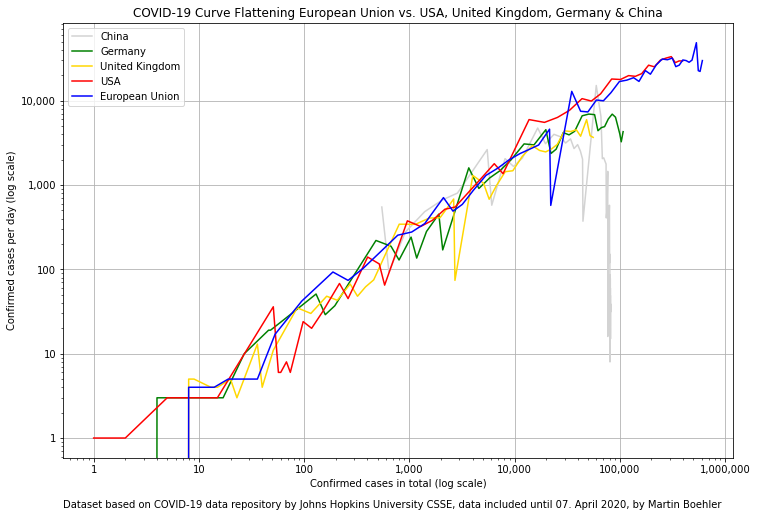

In [3]:
#hide_input
fig, ax = plt.subplots(figsize=(12, 8))

df_CN.plot(kind='line', x='confirmed', y='confirmed per day', label='China', color='lightgrey', ax=ax)
df_DE.plot(kind='line', x='confirmed', y='confirmed per day', label='Germany', color='green', ax=ax)
df_UK.plot(kind='line', x='confirmed', y='confirmed per day', label='United Kingdom', color='gold', ax=ax)
df_US.plot(kind='line', x='confirmed', y='confirmed per day', label='USA', color='red', ax=ax)
df_EU.plot(kind='line', x='confirmed', y='confirmed per day', label='European Union', color='blue', ax=ax)

ax.set(xscale='log',
       yscale='log',
       title='COVID-19 Curve Flattening European Union vs. USA, United Kingdom, Germany & China',
       xlabel='Confirmed cases in total (log scale)',
       ylabel='Confirmed cases per day (log scale)')

ax.annotate(s='Dataset based on COVID-19 data repository by Johns Hopkins University CSSE, data included until ' + format(df.date.max().strftime('%d. %B %Y')) + ', by Martin Boehler', 
            xy=(0, -50),
            xycoords='axes pixels',
            fontsize=10)

ax.get_xaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))

ax.grid()

## Adjusted Recovered Rate

The following charts visualize an adjusted recovered rate based on a weekly shifted confirmed rate.

The idea is, due to the fact that in some countries (e.g. *Germany*<sup>5</sup>) there is no obligation to report a patient's recovery, to get a better understanding of the estimated total number of people recovered, depending on how many weeks a person can be ill.

The datasets of the charts are based on the [*COVID-19* data repository](https://github.com/CSSEGISandData/COVID-19)<sup>4</sup> on *Github* by *Johns Hopkins University CSSE*.

### Germany

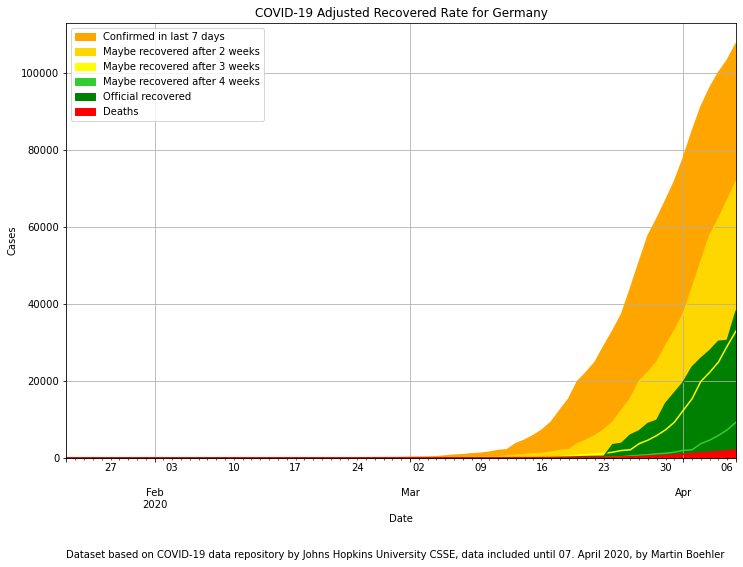

In [4]:
#hide_input
plotCountry(df_DE, 'Germany')

### Spain

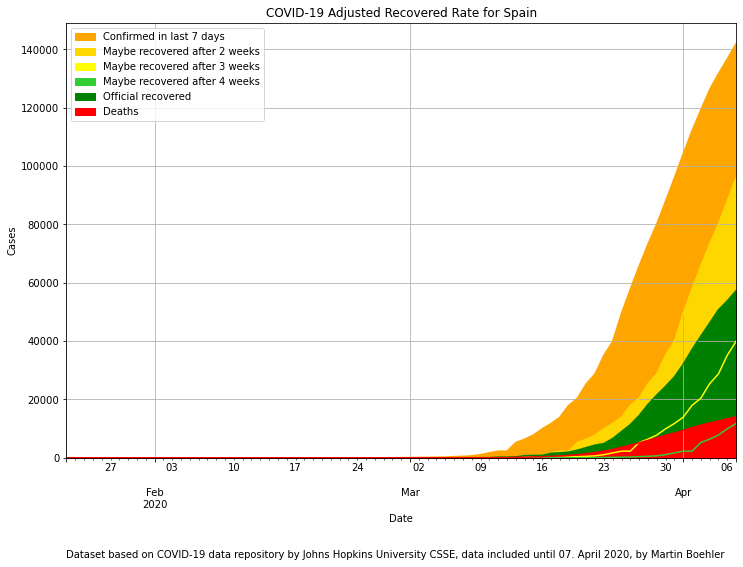

In [5]:
#hide_input
plotCountry(df_ES, 'Spain')

### Italy

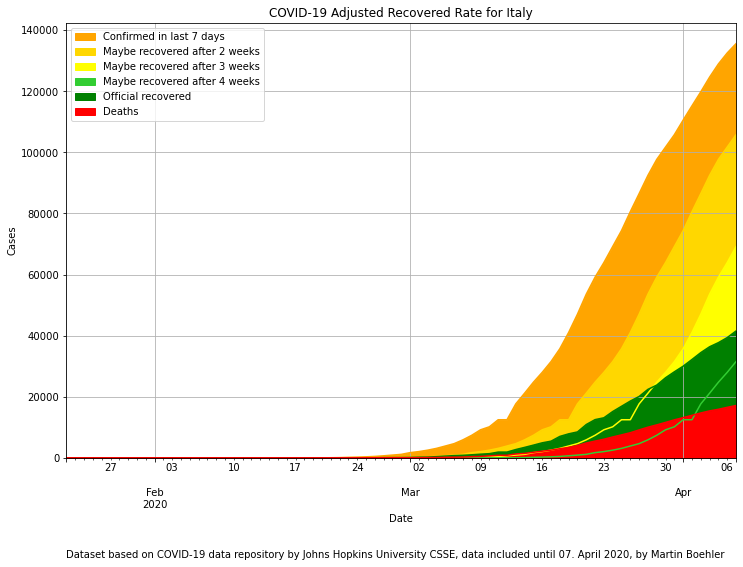

In [6]:
#hide_input
plotCountry(df_IT, 'Italy')

### France

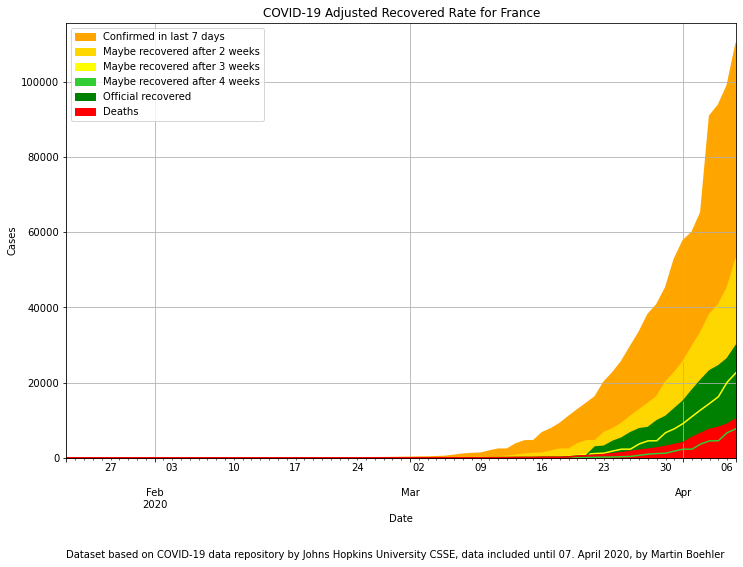

In [7]:
#hide_input
plotCountry(df_FR, 'France')

### European Union

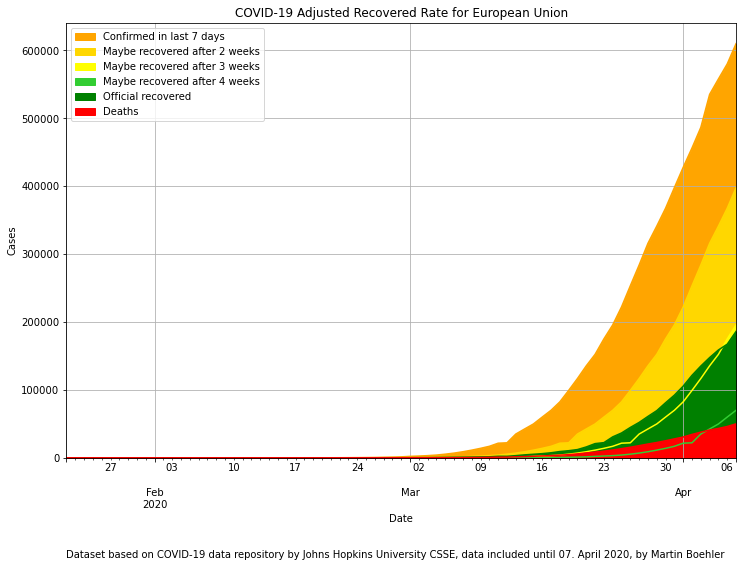

In [8]:
#hide_input
plotCountry(df_EU, 'European Union')

### United Kingdom

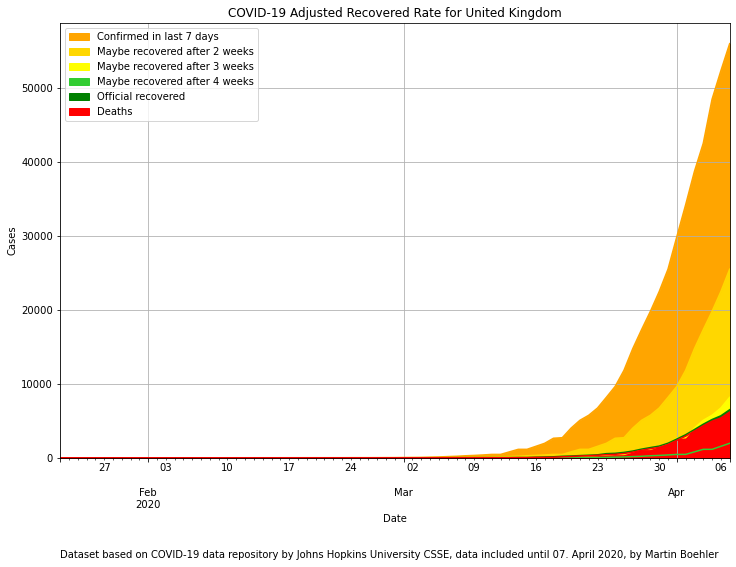

In [9]:
#hide_input
plotCountry(df_UK, 'United Kingdom')

### USA

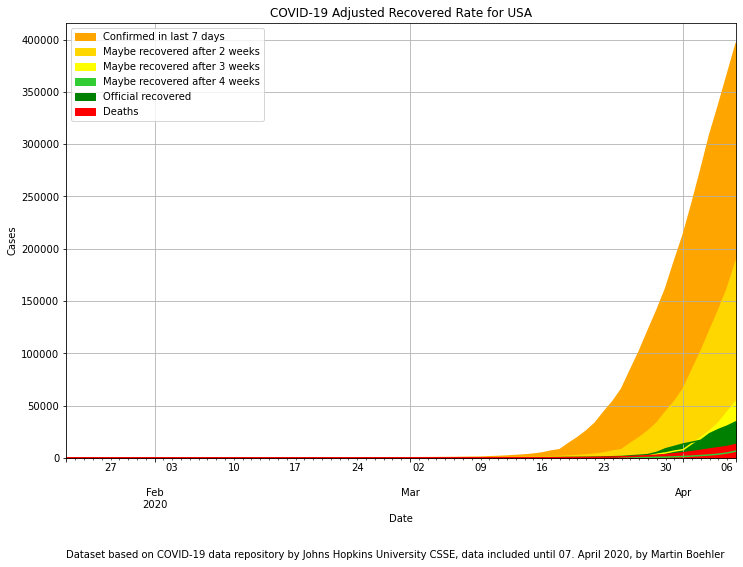

In [10]:
#hide_input
plotCountry(df_US, 'USA')

### China

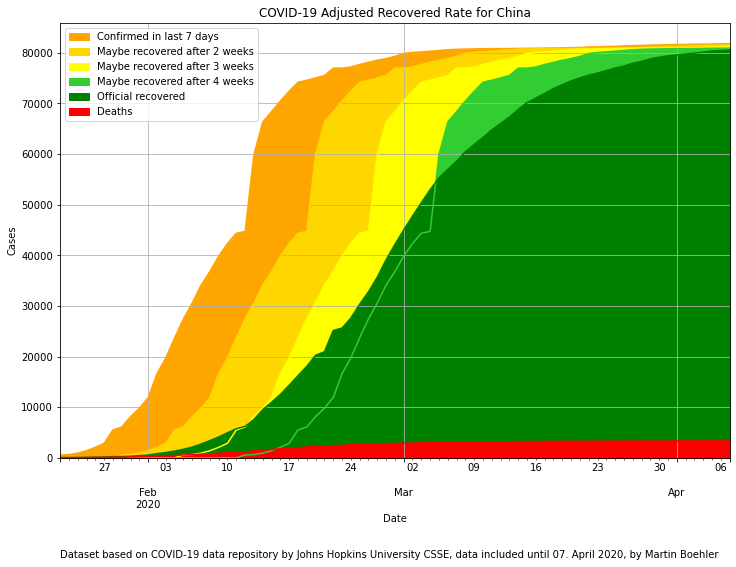

In [11]:
#hide_input
plotCountry(df_CN, 'China')

Dashboard developed by [Martin Boehler](https://www.linkedin.com/in/martin-boehler/)<sup>4</sup>.

1. [*European Union*](https://en.wikipedia.org/wiki/European_Union), description on *Wikipedia*.
2. [*US - Where is the curve flattening?*](https://covid19dashboards.com/us-inflection/), dashboard by *Daniel Cox*.
3. [*How To Tell If We're Beating COVID-19*](https://www.youtube.com/watch?v=54XLXg4fYsc), video by *Henry Reich* from [*minutephysics3*](https://www.youtube.com/channel/UCUHW94eEFW7hkUMVaZz4eDg)
4. The datasets of all charts are based on the [*2019 Novel Coronavirus COVID-19 (2019-nCoV) Data Repository*](https://github.com/CSSEGISandData/COVID-19) on [*Github*](https://github.com/) by [*Johns Hopkins University CSSE*](https://systems.jhu.edu/).
5. [*Antworten auf häufig gestellte Fragen zum Coronavirus SARS-CoV-2*](https://www.rki.de/SharedDocs/FAQ/NCOV2019/FAQ_Liste.html), FAQ page on [*Robert Koch Institute*](https://www.rki.de/EN/Home/homepage_node.html), *Germany*